<a href="https://colab.research.google.com/github/Sebin-Yoon/Skull-Stripping-CNN/blob/main/3D_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
from numpy import expand_dims
import cv2
import nibabel as nib 
import matplotlib.pyplot as plt
import glob
import pandas as pd
from pathlib import Path
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from keras import layers
import keras.backend as K
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization, Dropout
from tensorflow.keras.layers.experimental import preprocessing 
from tensorflow.keras.optimizers import *
from sklearn.model_selection import train_test_split
from IPython.display import clear_output


In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import the Data from drive

In [ ]:
# os.listdir(Path('/content/drive/MyDrive/NFBS_Dataset'))

Folder name will be patient name here
so make a dataframe to hold all the names

In [ ]:
patient_id_df = pd.DataFrame(os.listdir(Path('/content/drive/MyDrive/NFBS_Dataset')),columns=['id'])

Set the data path

In [ ]:
DATA_PATH = Path('/content/drive/MyDrive/NFBS_Dataset')

See how many patients we have

In [ ]:
patients = os.listdir(Path('/content/drive/MyDrive/NFBS_Dataset'))
len(patients)

125

#Time to set up the Training, testing, and validation set.

In [ ]:
TRAIN_PATH = Path('/content/drive/MyDrive/NFBS_Dataset')

In [ ]:
train_dir = [f.path for f in os.scandir(TRAIN_PATH) if f.is_dir()]

def list_to_ids(dir:str):
    """
    Will convert the dir paths to ids by parsing the paths.
    dir: string, image dir paths in BRATS
    """
    x = []
    for i in range(0,len(dir)):
        x.append(dir[i].split('/')[-1])
    return x

split up the data for training, validation, and testing

In [ ]:
# Now let's use the defined function
# Set a random state so the splits are the same
ids = list_to_ids(train_dir) 

# Split dataset to create training ids, validation ids and test ids
# Here we have selected the size of test set as 20% which is a common practice.
train_ids, test_ids = train_test_split(ids,test_size=0.2,random_state=42) 

# Create validation ids by further splitting the train ids, we again use 20% as size of valisation set. 
# Validation set is also referred to as tuning set. 

train_ids, val_ids = train_test_split(train_ids,test_size=0.2,random_state=42) 

In [ ]:
# print(f'There are {len(train_ids)} patient ids in training set')
# print(f'There are {len(val_ids)} patient ids in validation set')
# print(f'There are {len(test_ids)} patient ids in test set')

There are 80 patient ids in training set
There are 20 patient ids in validation set
There are 25 patient ids in test set


See how to access the data and pull the nifti images

##Take a look at the data

In [ ]:
# Test for file format #

# patient_id = 'A00034854'
# image = ''
# test = nib.load(Path(TRAIN_PATH,f'{patient_id}',f'sub-{patient_id}_ses-NFB3_T1w{image}.nii.gz'))
# plt.imshow(test._dataobj[:,test.shape[-1]//2, :], cmap='gray') 


In [ ]:
def read_patient_niftis(patient_id: str, data_path = TRAIN_PATH, niftis_to_load = ['brain','brainmask','']):
    patient_image_dict = {}
    for image in niftis_to_load:
        if image == '':
          patient_image_dict[image] = nib.load(Path(data_path,f'{patient_id}',f'sub-{patient_id}_ses-NFB3_T1w{image}.nii.gz'))
        else:
          patient_image_dict[image] = nib.load(Path(data_path,f'{patient_id}',f'sub-{patient_id}_ses-NFB3_T1w_{image}.nii.gz'))
    return (patient_image_dict)

In [ ]:
# Testing to see if all the nifti are the same size
# def count_shape():
#   shape = [];
#   for x in patients:
#     all_patients = read_patient_niftis(patient_id = x, data_path = TRAIN_PATH, niftis_to_load = ['brainmask'])
#     for i, (key, value) in enumerate(all_patients.items()):
#       shape.append(value.shape)
#   return (shape)

In [ ]:
pt_img_dict = read_patient_niftis(train_ids[12])

In [ ]:

# plt.figure(figsize=(45,30)) # specifying the overall grid size
# for i, (key, value) in enumerate(pt_img_dict.items()):
#     plt.subplot(1, 5, i+1)
#     img = value._dataobj[:, value.shape[-1]//2, :]
#     print(img.shape)
#     plt.imshow(img, cmap='gray') # Looks halfway through the volume. 
#     plt.axis('off')
#     #plt.title("{key1}, object shape: {shape}".format(key1=key,shape=value.shape), fontsize=30)
#     plt.title(key, fontsize=30)
# plt.show()

In [ ]:
for i, (key, value) in enumerate(pt_img_dict.items()):
    print(value.shape[2]) # Looks halfway through the volume. 
    #plt.title("{key1}, object shape: {shape}".format(key1=key,shape=value.shape), fontsize=30)


192
192
192


#Model set up test

In [ ]:
# Dice
def dice_coef(y_true, y_pred):
    """
    Dice coefficient for semantic segmentation.
    
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    
    y_true: The ground truth tensor.
    y_pred: The predicted tensor
    smooth: Smoothing factor. Default is 100.    
    """
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Jaccard/IoU
def jacard_coef(y_true, y_pred):
    """
    Jaccard coefficient for semantic segmentation. Also known as the IOU loss.
    
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    y_true: The ground truth tensor.
    y_pred: The predicted tensor
    smooth: Smoothing factor. Default is 100.    
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [ ]:
# The 2 loss functions we will look at are Dice and Jaccard loss

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)




#3D Unet Model Based off of Lecture

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate
# Define the UNet model
def get_unet(input_shape=(None, None, None, 1),
                  num_classes=1):
    inputs = Input(shape=input_shape)
    down1 = Conv3D(64, (3, 3, 3), activation = 'relu', padding='same')(inputs)
    down1 = BatchNormalization()(down1)
    down1 = Conv3D(64, (3, 3, 3), activation = 'relu', padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1_pool = MaxPooling3D((2, 2, 2), strides=(2, 2, 2))(down1)
    # 64

    down2 = Conv3D(128, (3, 3, 3), activation = 'relu', padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Conv3D(128, (3, 3, 3), activation = 'relu', padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2_pool = MaxPooling3D((2, 2, 2), strides=(2, 2, 2))(down2)
    # 32

    down3 = Conv3D(256, (3, 3, 3), activation = 'relu', padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Conv3D(256, (3, 3, 3), activation = 'relu', padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3_pool = MaxPooling3D((2, 2, 2), strides=(2, 2, 2))(down3)
    # 16

    down4 = Conv3D(512, (3, 3, 3), activation = 'relu', padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Conv3D(512, (3, 3, 3), activation = 'relu', padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4_pool = MaxPooling3D((2, 2, 2), strides=(2, 2, 2))(down4)
    # 8

    center = Conv3D(1024, (3, 3, 3), activation = 'relu', padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Conv3D(1024, (3, 3, 3), activation = 'relu', padding='same')(center)
    center = BatchNormalization()(center)
    # center

    up4 = UpSampling3D((2, 2, 2))(center)
    up4 = concatenate([down4, up4], axis=4)
    up4 = Conv3D(512, (3, 3, 3), activation = 'relu', padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Conv3D(512, (3, 3, 3), activation = 'relu', padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Conv3D(512, (3, 3, 3), activation = 'relu', padding='same')(up4)
    up4 = BatchNormalization()(up4)
    # 16

    up3 = UpSampling3D((2, 2, 2))(up4)
    up3 = concatenate([down3, up3], axis=4)
    up3 = Conv3D(256, (3, 3, 3), activation = 'relu', padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Conv3D(256, (3, 3, 3), activation = 'relu', padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Conv3D(256, (3, 3, 3), activation = 'relu', padding='same')(up3)
    up3 = BatchNormalization()(up3)
    # 32

    up2 = UpSampling3D((2, 2, 2))(up3)
    up2 = concatenate([down2, up2], axis=4)
    up2 = Conv3D(128, (3, 3, 3), activation = 'relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Conv3D(128, (3, 3, 3), activation = 'relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Conv3D(128, (3, 3, 3), activation = 'relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)
    # 64

    up1 = UpSampling3D((2, 2, 2))(up2)
    up1 = concatenate([down1, up1], axis=4)
    up1 = Conv3D(64, (3, 3, 3), activation = 'relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Conv3D(64, (3, 3, 3), activation = 'relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Conv3D(64, (3, 3, 3), activation = 'relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    # 128

    classify = Conv3D(1, (1, 1, 1), activation='sigmoid')(up1)

    model = Model(inputs=inputs, outputs=classify)
    model.compile(optimizer=Adam(learning_rate=0.00005), loss=dice_coef_loss, metrics=[dice_coef])
    return model

model = get_unet()

#2D Unet Model From Lecture

In [ ]:
org_img = pt_img_dict[''].get_fdata()
seg_img = pt_img_dict['brainmask'].get_fdata()

In [ ]:
# For this semantic segmentation task, we will use T2 images.
# And we will focus on binary or whole tumor (WT) segmentation. In order to do so we will assign the same pixel intensity (1) to the 3 tumor sub regions (1, 2, 4)


def normalize(input_image = org_img,
              input_mask = seg_img,
              percentile = 0.001,
              eps = 0.0000001):
    """
    Will read the input image and normalize the image between 0 and 1.
    Will read the input mask and assign pixel value 1 to all tumor subregions (1, 2, 4).
    input_image: default is t2_img, the image to be segmented.
    input_mask: default is seg_img, the ground truth or label.
    """
    img_array = np.ndarray.flatten(input_image)
    min_img, max_img = np.quantile(img_array, percentile), np.quantile(img_array, 1-percentile)
    img_normalized = ((input_image-min_img)/(max_img-min_img+eps)*255).astype(np.uint8)
    img_normalized = tf.cast(img_normalized, tf.float32) / 255
    
    mask_normalized = np.where(input_mask >=1, 1, 0)
    return img_normalized, mask_normalized


In [ ]:
def create_path_array(patient_ids:str,
                       DATA_PATH):
    data_path = DATA_PATH;
    x = [];
    y = [];
    for i, patient_id in enumerate(patient_ids):
          x.append(Path(data_path,f'{patient_id}',f'sub-{patient_id}_ses-NFB3_T1w.nii.gz'))
          y.append(Path(data_path,f'{patient_id}',f'sub-{patient_id}_ses-NFB3_T1w_brainmask.nii.gz'))
    return (x,y)

In [ ]:
from scipy import ndimage

def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


# def normalize(volume):
#     """Normalize the volume"""
#     min = -1000
#     max = 400
#     volume[volume < min] = min
#     volume[volume > max] = max
#     volume = (volume - min) / (max - min)
#     volume = volume.astype("float32")
#     return volume
def normalize(volume,
              percentile = 0.001,
              eps = 0.0000001):
    """
    Will read the input image and normalize the image between 0 and 1.
    Will read the input mask and assign pixel value 1 to all tumor subregions (1, 2, 4).
    input_image: default is t2_img, the image to be segmented.
    input_mask: default is seg_img, the ground truth or label.
    """
    img_array = np.ndarray.flatten(volume)
    min_img, max_img = np.quantile(img_array, percentile), np.quantile(img_array, 1-percentile)
    img_normalized = ((volume-min_img)/(max_img-min_img+eps)*255).astype(np.uint8)
    volume = tf.cast(img_normalized, tf.float32) / 255
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 128
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

In [ ]:
#Make path for the x and y

X_trainP, Y_trainP = create_path_array(train_ids, TRAIN_PATH)
X_valP, Y_valP = create_path_array(val_ids, TRAIN_PATH)
X_testP, Y_testP = create_path_array(test_ids, TRAIN_PATH)

In [ ]:
xTrainP = X_trainP[0];
YTrainP = Y_trainP[0]
XValP =X_valP[0]
YValP = Y_valP[0]
XtestP = X_testP[0]
YtestP = Y_testP
xTrainP

PosixPath('/content/drive/MyDrive/NFBS_Dataset/A00055373/sub-A00055373_ses-NFB3_T1w.nii.gz')

In [ ]:
# X_train = np.array([process_scan(path) for path in X_trainP])
# Y_train = np.array([process_scan(path) for path in Y_trainP])

# X_val = np.array([process_scan(path) for path in X_valP])
# Y_val = np.array([process_scan(path) for path in Y_valP])

X_test = np.array([process_scan(path) for path in X_testP])
Y_test = np.array([process_scan(path) for path in Y_testP])


#2 Image test
# X_train = np.array([process_scan(path) for path in X_trainP[0:2]])
# Y_train = np.array([process_scan(path) for path in Y_trainP[0:2]])

# X_val = np.array([process_scan(path) for path in X_valP[0:2]])
# Y_val = np.array([process_scan(path) for path in Y_valP[0:2]])

# X_test = np.array([process_scan(path) for path in X_testP[0:2]])
# Y_test = np.array([process_scan(path) for path in Y_testP[0:2]])

#1 image test
# X_train = np.array([process_scan(xTrainP)])
# Y_train = np.array([process_scan(YTrainP)])

# X_val = np.array([process_scan(XValP)])
# Y_val = np.array([process_scan(YValP)])

# X_test = np.array([process_scan(path) for path in X_testP[0:2]])
# Y_test = np.array([process_scan(path) for path in Y_testP[0:2]])

In [ ]:
# dataset_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
# dataset_train = dataset_train.map(lambda x, y: {'image': x, 'segmentation_mask': y})
# dataset_val = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
# dataset_val = dataset_val.map(lambda x, y: {'image': x, 'segmentation_mask': y})
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
dataset_test = dataset_test.map(lambda x, y: {'image': x, 'segmentation_mask': y})

In [ ]:
#Random rotations
import random
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    #volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [ ]:
TRAIN_LENGTH = len(train_ids)
BATCH_SIZE = 2
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
def load_image(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    return input_image, input_mask

In [ ]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
      super().__init__()
      # both use the same seed, so they'll make the same random changes.
      self.augment_inputs = preprocessing.RandomFlip(mode="horizontal_and_vertical", seed=seed)
      self.augment_labels = preprocessing.RandomFlip(mode="horizontal_and_vertical", seed=seed)

    def call(self, inputs, labels):
      inputs = self.augment_inputs(inputs)
      labels = self.augment_labels(labels)
      return inputs, labels

In [ ]:
# train_images = dataset_train.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
# val_images = dataset_val.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset_test.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# train_batches = (
#     train_images
#     .cache()
#     .shuffle(BUFFER_SIZE)
#     .batch(BATCH_SIZE)
#     .repeat()
#     .map(Augment())
#     .prefetch(buffer_size=tf.data.AUTOTUNE))

# val_batches = val_images.batch(BATCH_SIZE)
test_batches = test_images.batch(BATCH_SIZE)

In [ ]:
# print(model.input_shape)
# print(X_train.shape)
# print(X_train[0].size)
# print(max(X_train[0]))
temp_test = (X_train[0])
temp_test.shape

(64, 64, 64)

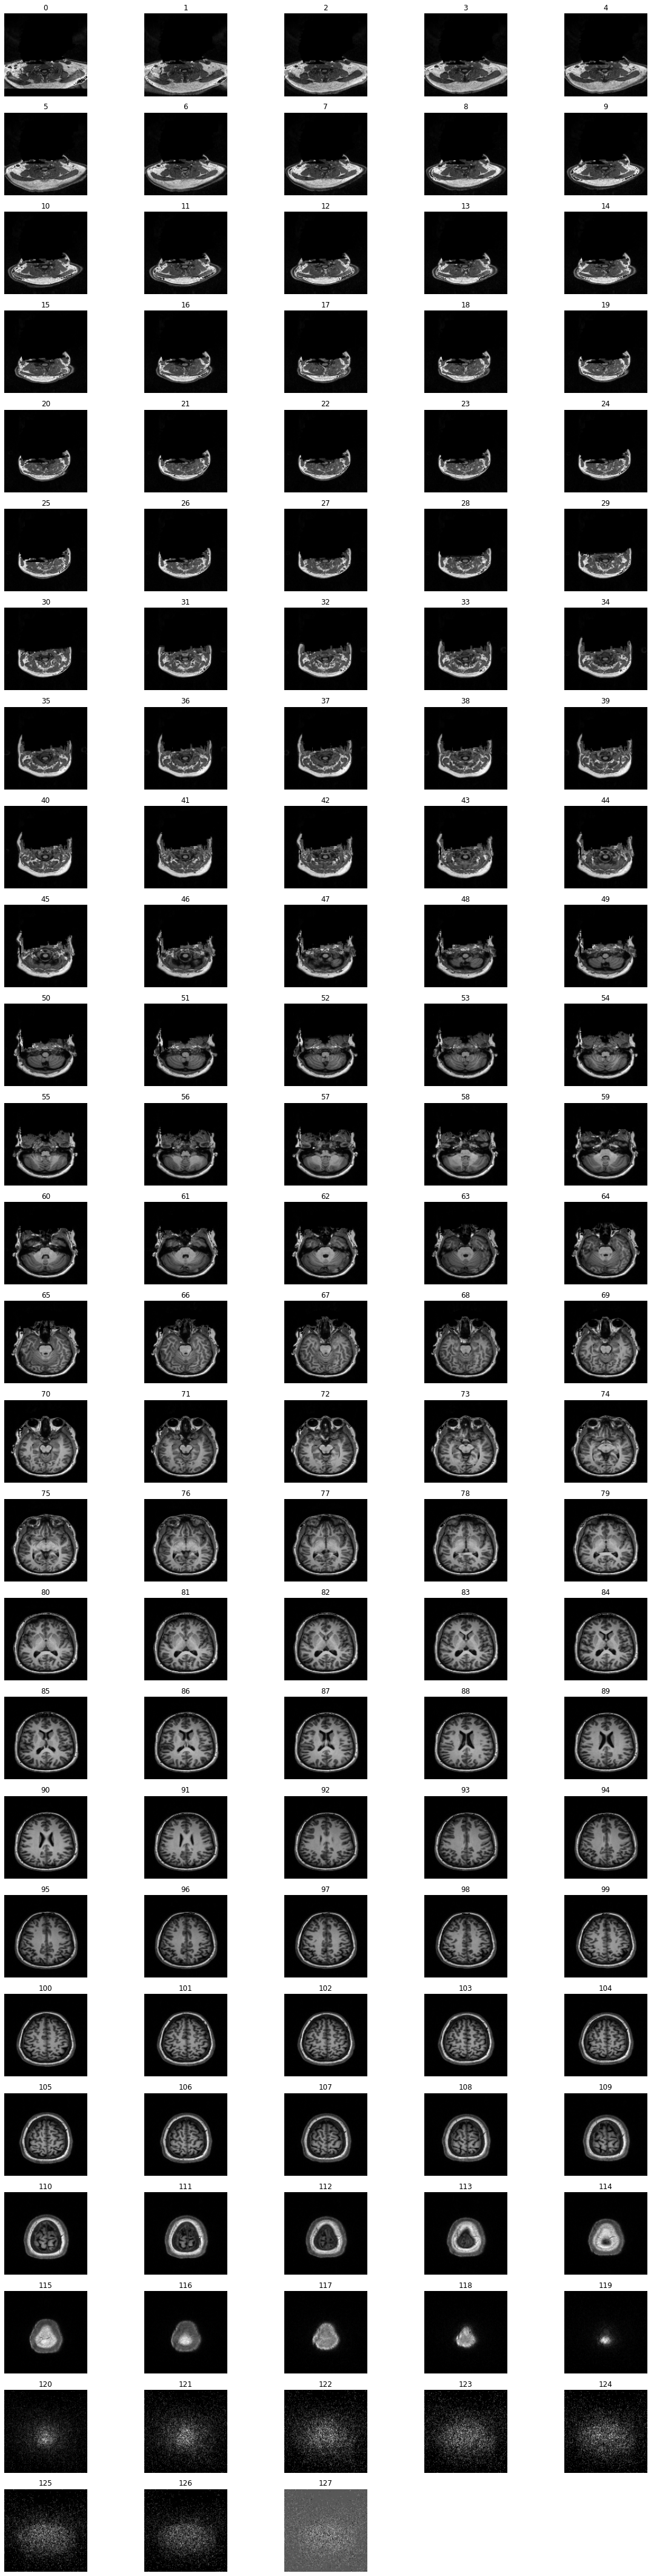

In [ ]:
    import math
    num_rows = math.ceil(len(X_test[0])/5)
    plt.figure(figsize = (20, 15*num_rows))
    for i, key in enumerate(X_test[0]): # iterates through the dictionary, while the enumerate function keeps track of the index with i
        plt.subplot(5*num_rows,5,i+1)    # the number of images in the grid 
        value = key
        img = value[:,:]
        plt.imshow(img, cmap= 'gray')
        plt.axis('off')
        plt.title(i)
    plt.show()

In [ ]:
# Let's train the model now
smooth = 1.
EPOCHS = 15
VAL_SUBSPLITS = 2
VALIDATION_STEPS = len(val_ids)//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_batches)
      

Epoch 1/15
40/40 [==============================] - 2207s 55s/step - loss: -0.5043 - dice_coef: 0.5043 - val_loss: -0.1426 - val_dice_coef: 0.1426
Epoch 2/15
40/40 [==============================] - 2211s 55s/step - loss: -0.6428 - dice_coef: 0.6428 - val_loss: -0.1159 - val_dice_coef: 0.1159
Epoch 3/15
40/40 [==============================] - 2214s 55s/step - loss: -0.6957 - dice_coef: 0.6957 - val_loss: -0.1048 - val_dice_coef: 0.1048
Epoch 4/15
40/40 [==============================] - 2215s 55s/step - loss: -0.7371 - dice_coef: 0.7371 - val_loss: -0.0170 - val_dice_coef: 0.0170
Epoch 5/15
40/40 [==============================] - 2215s 55s/step - loss: -0.7682 - dice_coef: 0.7682 - val_loss: -0.0529 - val_dice_coef: 0.0529
Epoch 6/15
40/40 [==============================] - 2213s 55s/step - loss: -0.7946 - dice_coef: 0.7946 - val_loss: -0.0073 - val_dice_coef: 0.0073
Epoch 7/15
40/40 [==============================] - 2198s 55s/step - loss: -0.8141 - dice_coef: 0.8141 - val_loss: -0.

In [ ]:
# model.save('/content/drive/MyDrive/saved_model/3d_unet_Model_test3') 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_model/3d_unet_Model_test3/assets


In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/saved_model/3d_unet_Model_test3', custom_objects={'dice_coef':dice_coef, 'dice_coef_loss':dice_coef_loss})


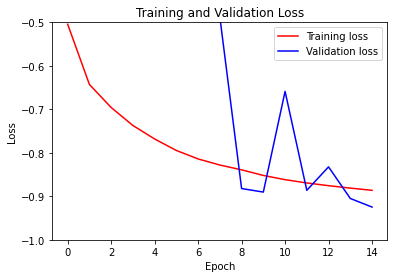

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([-1, -0.5])
plt.legend()
plt.show()

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
      plt.subplot(1, len(display_list), i+1)
      plt.title(title[i])
      plt.imshow((display_list[i]), cmap = 'gray')
      plt.axis('off')
    plt.show()

In [ ]:
# Let's write a function to show the predictions
def show_predictions(dataset=None, num=1):
    if dataset:
      for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        #print(image[0,:,32,:].shape)
        display([image[0,87,:,:], mask[0,87,:,:], pred_mask[0,87,:,:,0]])

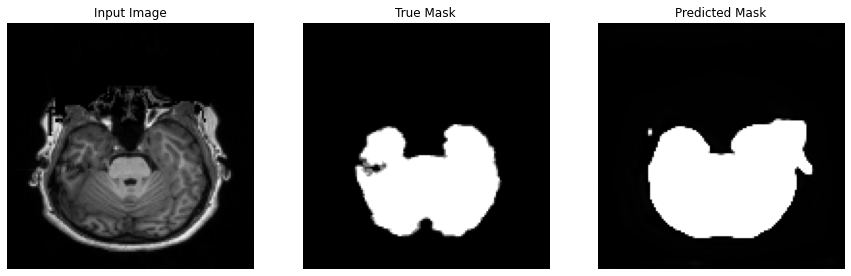

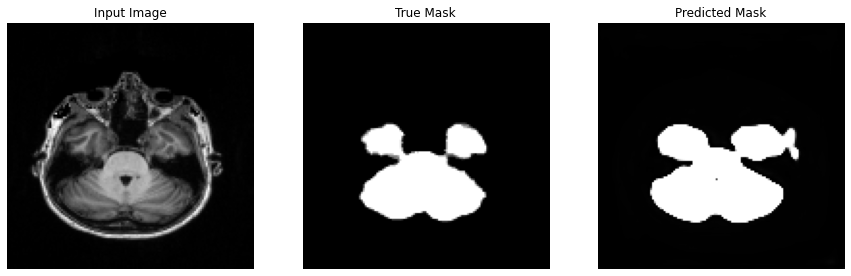

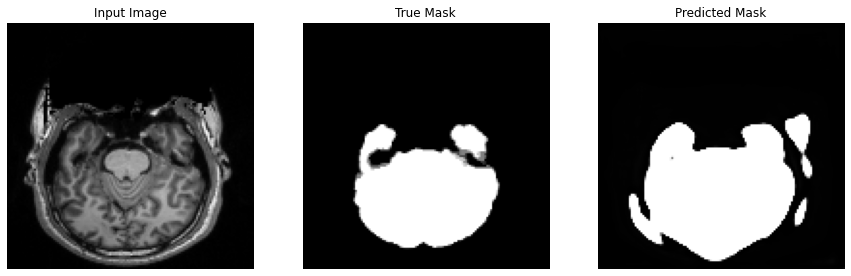

In [ ]:
show_predictions(test_batches, 3)

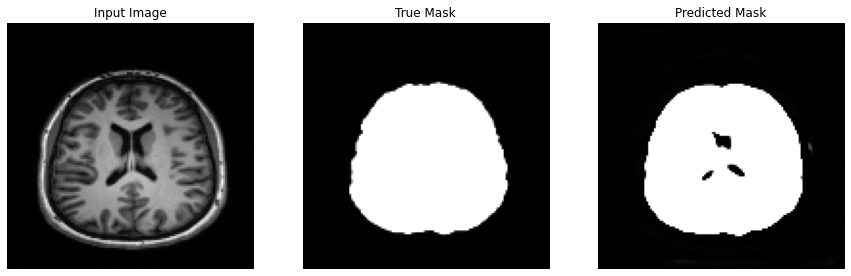

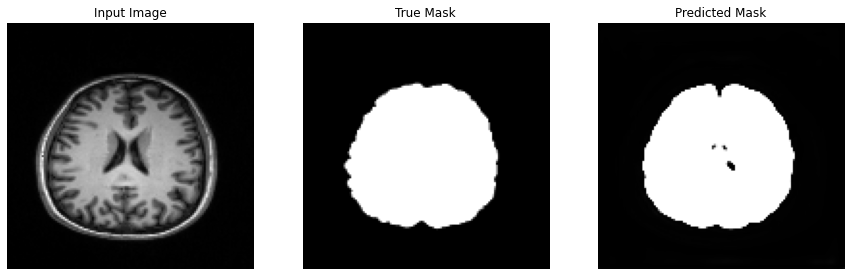

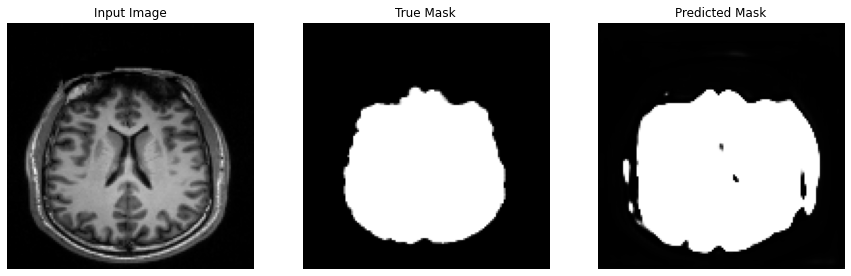

In [ ]:
show_predictions(test_batches, 3)

In [ ]:
def show_predictions(dataset=None, num=1):
    if dataset:
      for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        #print(image[0,:,32,:].shape)
        display([image[0,42,:,:], mask[0,42,:,:], pred_mask[0,42,:,:,0]])

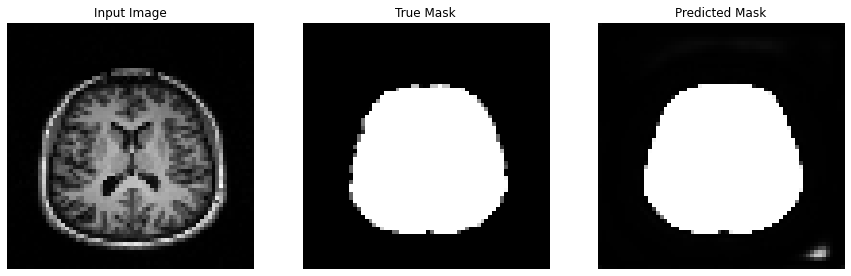

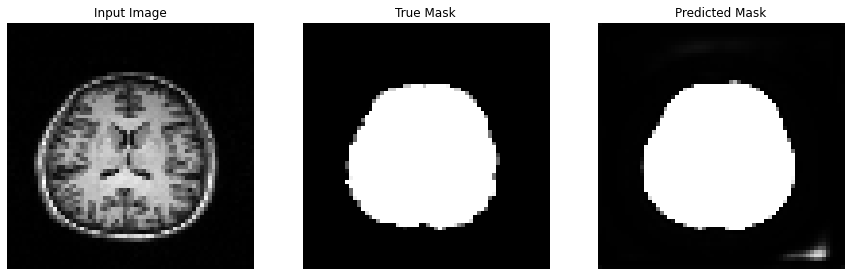

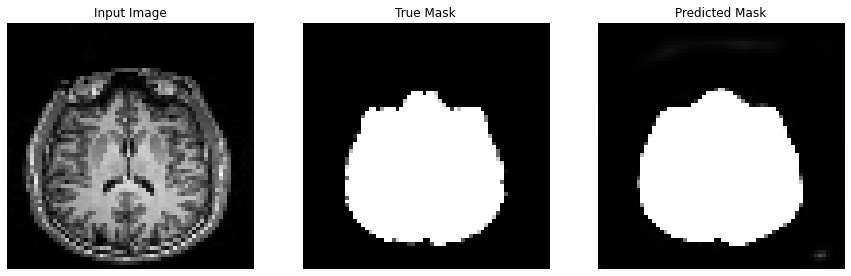

In [ ]:
show_predictions(test_batches, 3)